In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

#all_letters = "aábdðeéfghiíjklmnoóprstuúvxyýþæöAÁBDÐEÉFGHIÍJKLMNOÓPRSTUÚVXYÝÞÆÖ" + " .,;'-"

all_letters = "aábdðeéfghiíjklmnoóprstuúvxyýþæöAÁBDEFGHIÍJKLMNOÓPRSTUÚVYÞÖ" + " .,;'-"
print(all_letters)
#n_letters = len(all_letters) + 1 # Plus EOS marker

n_letters = len(all_letters) + 1 # Plus EOS marker

print(n_letters)

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [line.strip() for line in some_file]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data_indep/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))
print(category_lines)

aábdðeéfghiíjklmnoóprstuúvxyýþæöAÁBDEFGHIÍJKLMNOÓPRSTUÚVYÞÖ .,;'-
66
# categories: 2 ['mountains', 'towns']
O'Neal
{'mountains': ['Akrafjall', 'Arnarbæli', 'Askja', 'Ausufjall', 'Ármannsfell', 'Baula', 'Bárðarbunga', 'Bjarnarfjall', 'Bjólfell', 'Bláfell', 'Bláfjall', 'Bláfjöll', 'Bláhnúkur', 'Blámannshattur', 'Bolafjall', 'Botnssúlur', 'Brennisteinsalda', 'Brennisteinsfjöll', 'Búlandshöfði', 'Búlandstindur', 'Búrfell', 'Búrfellshyrna', 'Búrfjöll', 'Bæjarfel', 'Böggvisstaðafjall', 'Dímon', 'Drangaskörð', 'Drápuhlíðarfjall', 'Dyngjufjöll', 'Dyrfjöll', 'Dýjafjallshnjúkur', 'Efstadalsfjall', 'Einhyrningur', 'Eiríksjökull', 'Ernir', 'Esja', 'Esjufjöll', 'Eyjafjallajökull', 'Eyjafjöll', 'Eyrarfjall', 'Eystrahorn', 'Fagradalsfjall', 'Fagraskógarfjall', 'Fjórðungsalda', 'Geirólfsgnúpur', 'Gerpir', 'Gjögur', 'Gloppuhnjúkur', 'Glóðafeykir', 'Grábrók', 'Grettisbæli', 'Grímsfjall', 'Grænadyngja', 'Gunnólfsvíkurfjall', 'Göltur', 'Hafnarfjall', 'Hafursey', 'Hattfell', 'Hágöngur', 'Heiðarfjall', 'Hei

In [252]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.15)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [253]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [254]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [255]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

print(randomTrainingExample()[2])

tensor([ 5, 22, 10, 14,  3, 27, 16,  8, 12,  0, 65])


In [256]:
criterion = nn.NLLLoss()

learning_rate = 0.0003

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [257]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [258]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 5*100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 13s (5000 1%) 3.0436
0m 26s (10000 2%) 3.8118
0m 39s (15000 3%) 3.1211
0m 51s (20000 4%) 3.2313
1m 4s (25000 5%) 2.7330
1m 17s (30000 6%) 2.0757
1m 30s (35000 7%) 1.4571
1m 43s (40000 8%) 2.8165
1m 56s (45000 9%) 3.0493
2m 9s (50000 10%) 2.1337
2m 22s (55000 11%) 1.8581
2m 35s (60000 12%) 2.9865
2m 48s (65000 13%) 2.3963
3m 1s (70000 14%) 1.9076
3m 14s (75000 15%) 1.8128
3m 27s (80000 16%) 1.6890
3m 40s (85000 17%) 1.4303
3m 53s (90000 18%) 1.5423
4m 6s (95000 19%) 1.8044
4m 19s (100000 20%) 2.4884
4m 32s (105000 21%) 1.3148
4m 45s (110000 22%) 1.9120
4m 58s (115000 23%) 0.9757
5m 11s (120000 24%) 1.6333
5m 24s (125000 25%) 1.1594
5m 37s (130000 26%) 1.2559
5m 50s (135000 27%) 1.5318
6m 3s (140000 28%) 1.0087
6m 16s (145000 28%) 1.0572
6m 29s (150000 30%) 1.0811
6m 41s (155000 31%) 0.6361
6m 54s (160000 32%) 1.6660
7m 7s (165000 33%) 0.5250
7m 20s (170000 34%) 0.8747
7m 33s (175000 35%) 1.5258
7m 46s (180000 36%) 2.0582
8m 0s (185000 37%) 0.8791
8m 13s (190000 38%) 1.2403
8m 26s (19

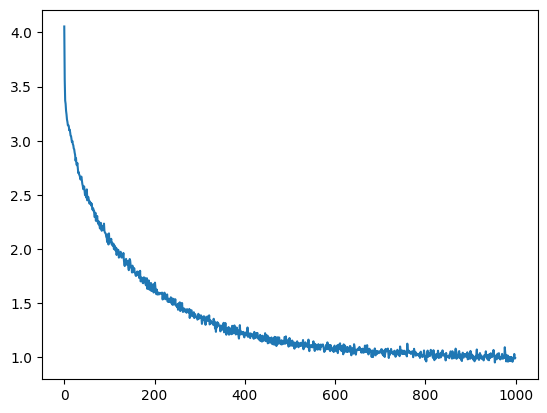

In [259]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

In [260]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

""" samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI') """

print("######### Towns #########")
samples('towns', 'AÁBDEFGHIÍJKLMNOÓPRSTUÚVYÞÖ')
print('')
print("######### Mountains #########")
samples('mountains', 'AÁBDEFGHIÍJKLMNOÓPRSTUÚVYÞÖ')

######### Towns #########
Akureyri
Árbæjarhvrman
Borgjang
Drangsnes
Eyrarbakki
Flúðir
Grímseynjuré
Helgivsjuruðr
Innnes
Ísaák
Jarlhetr
Kópavogur
Laugarbabribr
Mosferlibarkr
Neskaupsafður
Ok
Óshyrna
Prereshöjörðej
Reykjanesbær
Staðkagróður
Tralaheiðkururul
Uaptjorungnr
Úlfarsfels
Vaðamheiðr
Yarkarbær
Þórshöfn
Örafargin

######### Mountains #########
Akrafjallbjikhll
Álstannúaná
Bláfjöll
Dyngjufjöll
Eyrifjölá
Flórðungsalúh
Græturengogn
Hella
Ingnafsfjill
Ísafjörður
Jarlhettéi
Klopnjágrsja
Langadalsfjall
Moldavirfaöll
Nesjahletai
Ok
Óshyrna
Paturaun
Raufallksa
Stóllinn
Trarfjölg
Uppalítyrfjall
Úlfarngelíksejaák
Vatnadldsfjaal
Yarfjöll
Þorfálsngaladal
Öræfajökullda


In [261]:
""" PATH = './test_net.pth'
torch.save(rnn.state_dict(), PATH) """

" PATH = './test_net.pth'\ntorch.save(rnn.state_dict(), PATH) "